In [106]:
# %pip install libpysal
# %pip install spopt
# %pip install --upgrade geopandas


In [23]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Polygon, mapping
import h3
import folium

from scipy import stats

import libpysal
import spopt
from sklearn.metrics import pairwise as skm
from matplotlib import pyplot as plt


In [3]:
# def moment_2(a):
#     return (moment(a, moment=2)**(1/2))

# def moment_3(a):
#     return moment(a, moment=3)**(1/3)

# def moment_4(a):
#     return moment(a, moment=4)**(1/4)

In [4]:
df_mun = gpd.read_file('BR_Municipios_2022/BR_Municipios_2022.shp')
df_mun = df_mun[df_mun['SIGLA_UF'] == 'SP'].reset_index(drop=True)

df_mun.shape

(645, 5)

In [5]:
df_mun.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,3500105,Adamantina,SP,411.987,"POLYGON ((-51.09557 -21.57029, -51.09617 -21.5..."
1,3500204,Adolfo,SP,211.055,"POLYGON ((-49.61249 -21.26110, -49.61249 -21.2..."
2,3500303,Aguaí,SP,474.554,"POLYGON ((-47.01254 -22.00527, -47.01219 -22.0..."
3,3500402,Águas da Prata,SP,142.673,"POLYGON ((-46.71875 -21.95837, -46.71878 -21.9..."
4,3500501,Águas de Lindóia,SP,60.126,"POLYGON ((-46.61761 -22.51172, -46.61864 -22.5..."


In [6]:
np.random.seed(42)

random_numbers = np.random.randint(1,101, size = 10000)
random_indexes = np.random.randint(0, 645, size=10000)



dados = pd.DataFrame(random_numbers, columns=['score'])
dados['mun'] = df_mun['CD_MUN'].values[random_indexes]

dados.head()

,score,mun
0,52,3514924
1,93,3549201
2,15,3515707
3,72,3555000
4,61,3554706


In [7]:
grouped = dados.groupby('mun').agg({ 'score':  [np.median, np.mean, np.std, stats.skew, stats.kurtosis]}).reset_index()

grouped.columns = ['_'.join(c) for c in grouped.columns]

In [8]:
grouped.head()

,mun_,score_median,score_mean,score_std,score_skew,score_kurtosis
0,3500105,35.0,40.812500,27.095433,0.537069,-0.935253
1,3500204,55.5,56.916667,21.993629,0.585227,-0.518448
2,3500303,57.0,53.764706,28.867216,-0.139300,-1.118315
3,3500402,45.0,43.000000,30.809901,0.185177,-1.103936
4,3500501,71.5,66.800000,27.571322,-0.590879,-0.521440


In [9]:
df_mun = df_mun.merge(grouped, left_on='CD_MUN', right_on='mun_', how='left')

In [10]:
df_mun.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,mun_,score_median,score_mean,score_std,score_skew,score_kurtosis
0,3500105,Adamantina,SP,411.987,"POLYGON ((-51.09557 -21.57029, -51.09617 -21.5...",3500105,35.0,40.812500,27.095433,0.537069,-0.935253
1,3500204,Adolfo,SP,211.055,"POLYGON ((-49.61249 -21.26110, -49.61249 -21.2...",3500204,55.5,56.916667,21.993629,0.585227,-0.518448
2,3500303,Aguaí,SP,474.554,"POLYGON ((-47.01254 -22.00527, -47.01219 -22.0...",3500303,57.0,53.764706,28.867216,-0.139300,-1.118315
3,3500402,Águas da Prata,SP,142.673,"POLYGON ((-46.71875 -21.95837, -46.71878 -21.9...",3500402,45.0,43.000000,30.809901,0.185177,-1.103936
4,3500501,Águas de Lindóia,SP,60.126,"POLYGON ((-46.61761 -22.51172, -46.61864 -22.5...",3500501,71.5,66.800000,27.571322,-0.590879,-0.521440


In [11]:
# help(libpysal.weights.Queen.from_dataframe)

In [17]:
w = libpysal.weights.Queen.from_dataframe(df_mun, idVariable = 'CD_MUN')

/opt/anaconda3/envs/mapas/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 3520400.
  warnings.warn(message)


In [57]:
def model_skater(w, 
                df, 
                attrs_name, 
                n_clusters, 
                floor =1, 
                trace=False, 
                islands= 'increase', 
                spanning_forest_kwds=dict(
                        dissimilarity=skm.manhattan_distances,
                        affinity=None,
                        reduction=np.sum,
                        center=np.mean,
                        verbose=-1
                    )):

    skater = spopt.region.Skater(
            df,
            w,
            attrs_name,
            n_clusters=n_clusters,
            floor=floor,
            trace=trace,
            islands=islands,
            spanning_forest_kwds=spanning_forest_kwds
        )
        
    return skater

In [58]:
for m in ['score_median', 'score_mean', 'score_std', 'score_skew', 'score_kurtosis']:
    skater = model_skater(w, df_mun, [m], 5)
    skater.solve()
    df_mun[m+'_cluster'] = skater.labels_

/opt/anaconda3/envs/mapas/lib/python3.7/site-packages/spopt/region/skater.py:457: OptimizeWarning: By default, the graph is disconnected! Increasing `n_clusters` from 5 to 7 in order to account for islands.
  islands=self.islands,
finding cut...: 100%|██████████| 639/639 [00:01<00:00, 439.65it/s]
/opt/anaconda3/envs/mapas/lib/python3.7/site-packages/spopt/region/skater.py:457: OptimizeWarning: By default, the graph is disconnected! Increasing `n_clusters` from 5 to 7 in order to account for islands.
  islands=self.islands,
finding cut...: 100%|██████████| 639/639 [00:02<00:00, 279.85it/s]
/opt/anaconda3/envs/mapas/lib/python3.7/site-packages/spopt/region/skater.py:457: OptimizeWarning: By default, the graph is disconnected! Increasing `n_clusters` from 5 to 7 in order to account for islands.
  islands=self.islands,
finding cut...: 100%|██████████| 639/639 [00:01<00:00, 386.06it/s]
/opt/anaconda3/envs/mapas/lib/python3.7/site-packages/spopt/region/skater.py:457: OptimizeWarning: By defa

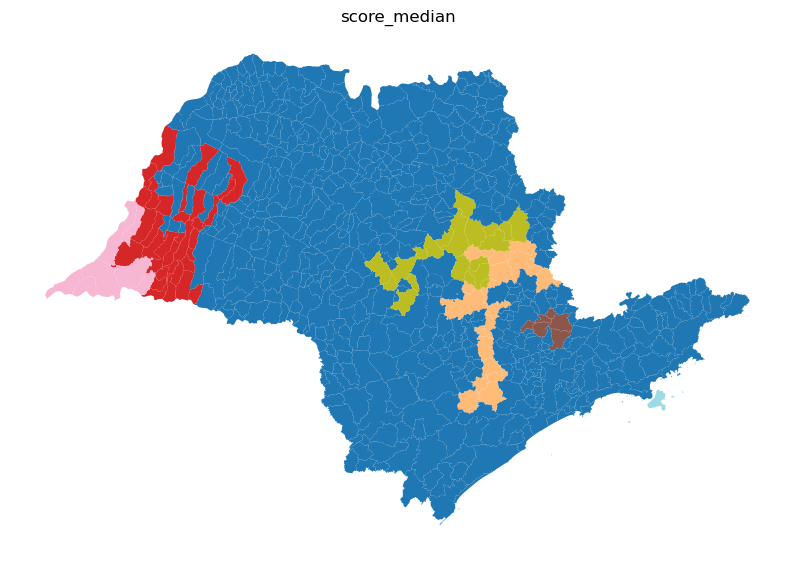

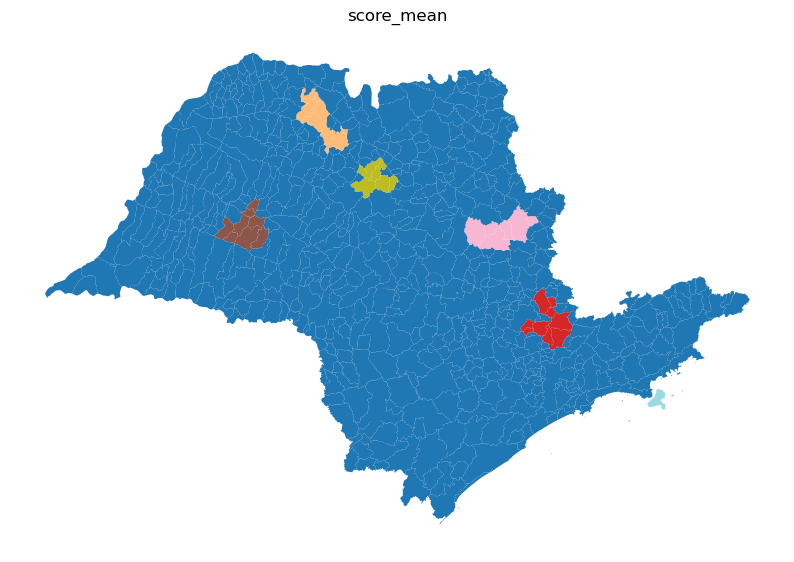

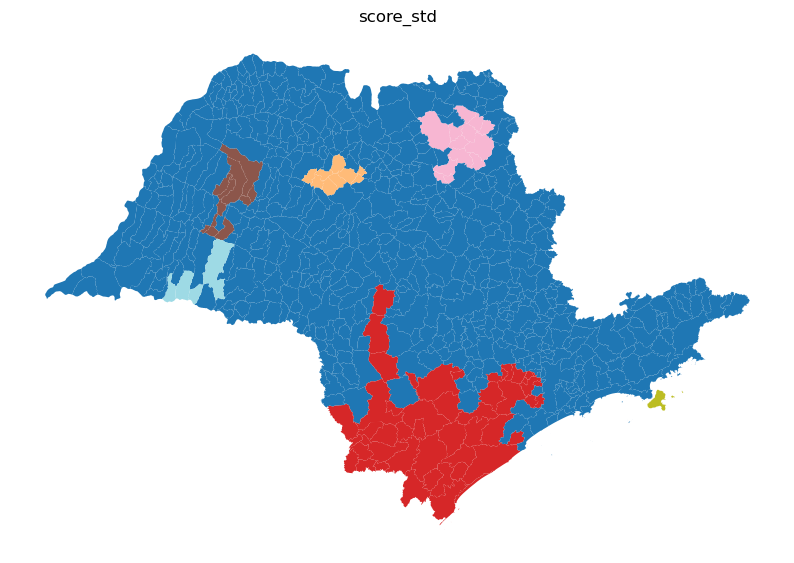

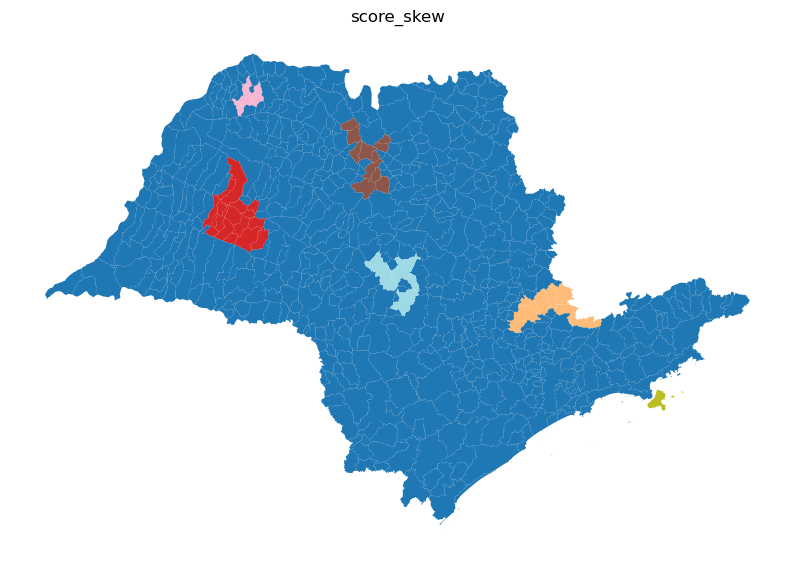

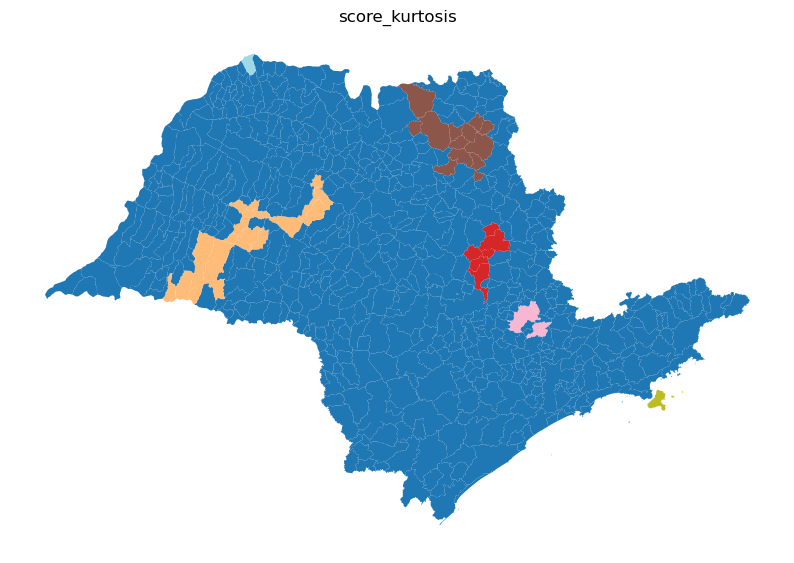

In [59]:
for m in ['score_median', 'score_mean', 'score_std', 'score_skew', 'score_kurtosis']:
    df_mun.plot(column=m+'_cluster', cmap='tab20', figsize=(10,10), legend=False).axis("off")
    plt.title(m)
    plt.show()

In [60]:
m = ['score_median', 'score_mean', 'score_std', 'score_skew', 'score_kurtosis']

for i in range(10, 11):
    skater = model_skater(w, df_mun, m, i)
    skater.solve()
    df_mun['cluster_'+str(i)] = skater.labels_

/opt/anaconda3/envs/mapas/lib/python3.7/site-packages/spopt/region/skater.py:457: OptimizeWarning: By default, the graph is disconnected! Increasing `n_clusters` from 10 to 12 in order to account for islands.
  islands=self.islands,
finding cut...: 100%|██████████| 634/634 [00:03<00:00, 204.98it/s]


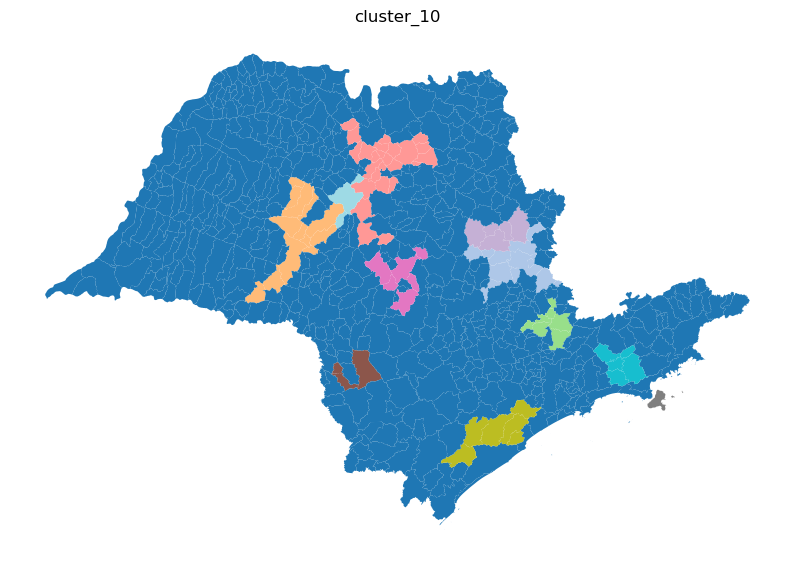

In [61]:
for i in range(10, 11):
    df_mun.plot(column='cluster_'+str(i), cmap='tab20', figsize=(10,10), legend=False).axis("off")
    plt.title('cluster_'+str(i))
    plt.show()


In [62]:
df_mun_simplified = df_mun.copy()
df_mun_simplified['geometry'] = df_mun.simplify(tolerance=0.01)

In [63]:
w_simplified = libpysal.weights.Queen.from_dataframe(df_mun_simplified, idVariable = 'CD_MUN')

/opt/anaconda3/envs/mapas/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 10 islands with ids: 3500402, 3510609, 3516309, 3520400, 3523107, 3525003, 3539806, 3544103, 3556453, 3556503.
  warnings.warn(message)


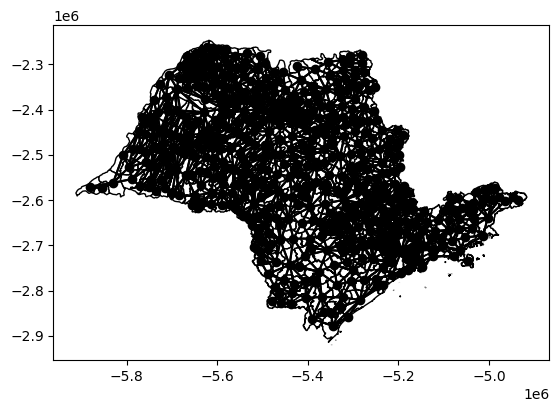

In [64]:
w.plot(df_mun.to_crs(3857), indexed_on='CD_MUN')
df_mun.to_crs(3857).plot(ax=plt.gca(), zorder=0, color='w', edgecolor='k')

plt.show()

In [65]:
m = ['score_median', 'score_mean', 'score_std', 'score_skew', 'score_kurtosis']

for i in range(10,11):
    skater = model_skater(w_simplified, df_mun_simplified, m, i)
    skater.solve()
    df_mun_simplified['cluster_'+str(i)] = skater.labels_

/opt/anaconda3/envs/mapas/lib/python3.7/site-packages/spopt/region/skater.py:457: OptimizeWarning: By default, the graph is disconnected! Increasing `n_clusters` from 10 to 23 in order to account for islands.
  islands=self.islands,
finding cut...:   0%|          | 0/632 [00:00<?, ?it/s]

finding cut...: 100%|██████████| 623/623 [00:04<00:00, 130.56it/s]


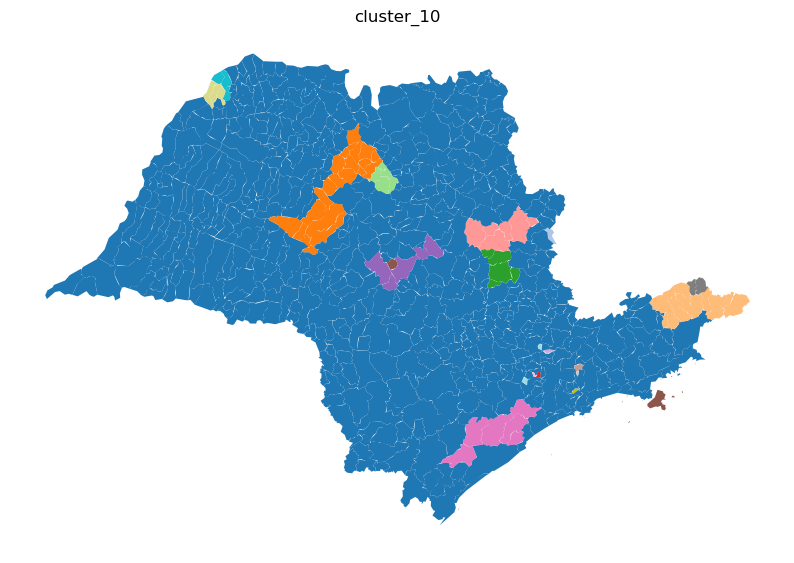

In [66]:
for i in range(10,11):
    df_mun_simplified.plot(column='cluster_'+str(i), cmap='tab20', figsize=(10,10), legend=False).axis("off")
    plt.title('cluster_'+str(i))
    plt.show()